# Feature Analysis - Support Vector Machine

### Import required libraries

In [1]:
import sys, os
import itertools
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.utils import resample

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def progressBar(value, endvalue, bar_length=50):
    percent = float(value) / endvalue
    arrow = '=' * int(round(percent * bar_length)-1) + '>'
    spaces = ' ' * (bar_length - len(arrow))

    sys.stdout.write("\r[{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))

### Import Data

In [3]:
data = pd.read_csv(os.path.join(os.path.abspath(os.pardir), 'src/dataset', 'data_101718.csv'), low_memory=False)

In [4]:
data.head()

,pid,xnorm,ynorm,znorm,cardistnorm,ca,voxelcount0i,graylevels0i,energy0i,entropy0i,...,srlgle15c,srhgle15c,lrlgle15c,lrhgle15c,extrudedsurfacearea15c,extrudedvolume15c,extrudedsurfacevolumeratio15c,boxcountingdimension15c,informationdimension15c,correlationdimension15c
0,129381,-40.78346,-8.199849,29.363550,50.91901,0,10.0,10.0,2221248.0,0.000000,...,0.000351,17872.487,0.000949,42115.337,4760376.9,10073969.0,0.472542,2.091545,2.098287,-74.249922
1,100676,-53.82082,-38.156560,-3.371359,66.06035,0,351.0,260.0,176300000.0,200.078200,...,0.023536,13326.403,0.107683,45091.633,6061283.1,10260464.0,0.590742,2.065475,2.089445,-73.135671
2,132772,49.27720,-35.530340,-1.662529,60.77345,0,18.0,18.0,2805381.0,0.000000,...,0.000159,54901.246,0.000356,174473.340,6801351.9,11157162.0,0.609595,2.189789,2.194593,-78.016611
3,126967,21.59079,15.484310,27.472460,38.21861,1,1374.0,625.0,135400000.0,1900.617600,...,0.005102,37566.835,0.012797,163982.200,6179906.4,9170642.1,0.673879,2.145406,-0.061130,-76.017566
4,102562,80.64488,16.086080,-69.602640,107.73530,0,173.0,159.0,46611581.0,28.754888,...,0.000151,210927.090,0.000230,671420.660,8901488.9,8746977.7,1.017664,2.117663,-0.058523,-74.898571


In [5]:
data.shape

(3701, 274)

### Data Cleaning 

Let's take a look at the missing data, and try to figure our the best way to clean up our data.

Drop out the columns that have over 90% missing data points.

In [6]:
df = data.dropna(thresh=len(data)*.90, axis=1)

Drop out any rows that are missing more than 50% of the required columns

In [7]:
df = df.dropna(thresh=df.shape[1]*.5)

Drop out any rows that are missing the target value 

In [8]:
df = df.dropna(axis=1, subset=df['ca'])

Fill the rest of missing entries with the mean of each col

In [9]:
df = df.apply(lambda col: col.fillna(col.mean()))

In [10]:
df.isnull().sum().any()

False

### Data Cleaning

In [11]:
features = list(df.columns.values)
features.remove('pid')
features.remove('ca')

Let's balance out the pos and neg samples in the dataset

In [12]:
df_neg = df[df.ca==0]
df_pos = df[df.ca==1]

Upsample the pos samples

In [13]:
df_pos_upsampled = resample(
    df_pos,
    n_samples=len(df_neg),
    replace=True, 
    random_state=2018
)
df_upsampled = pd.concat([df_pos_upsampled, df_neg])

Downsample the neg samples

In [14]:
df_neg_downsampled = resample(
    df_neg,
    n_samples=len(df_pos),
    replace=True, 
    random_state=2018
)
df_downsampled = pd.concat([df_pos, df_neg_downsampled])

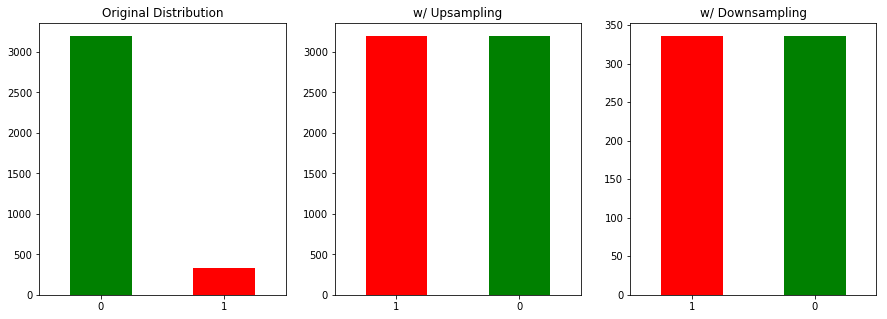

In [15]:
fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=3)
df.ca.value_counts().plot.bar(ax=axes[0], rot=False, title='Original Distribution', color=['g','r'])
df_upsampled.ca.value_counts().plot.bar(ax=axes[1], rot=False, title='w/ Upsampling', color=['r','g'])
df_downsampled.ca.value_counts().plot.bar(ax=axes[2], rot=False, title='w/ Downsampling', color=['r','g'])

### Setup Classifier

Normalize Data

In [16]:
# original distribution
#X = StandardScaler().fit_transform(df[features])
#y = df.ca.values

# w/upsampling
#X = StandardScaler().fit_transform(df_upsampled[features])
#y = df_upsampled.ca.values

# w/downsampling
X = StandardScaler().fit_transform(df_downsampled[features])
y = df_downsampled.ca.values

In [17]:
pca = PCA(n_components=3)
inception = pca.fit(X).transform(X)

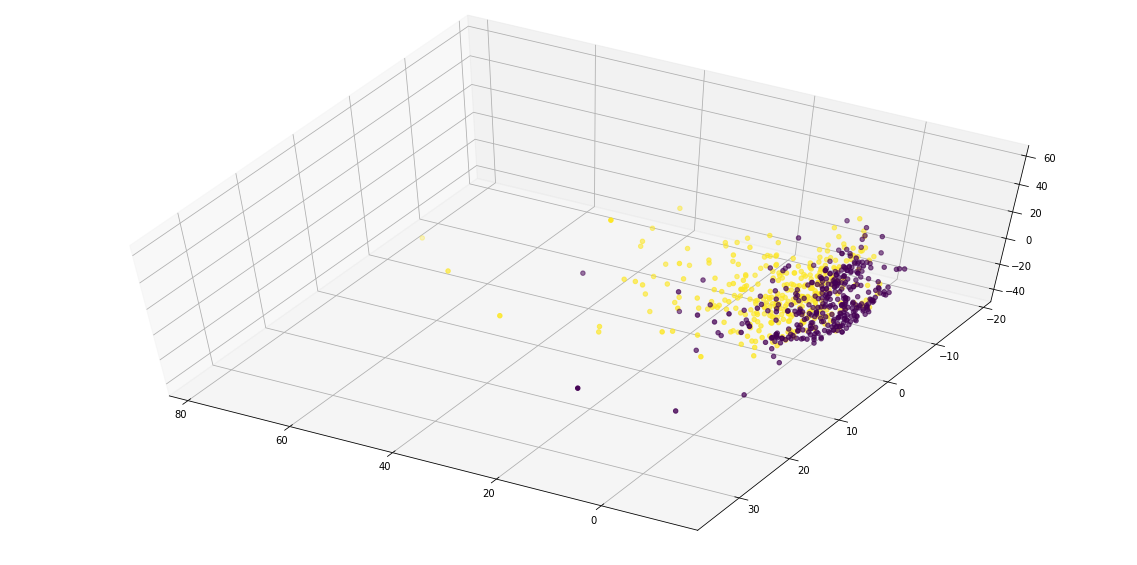

In [18]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(inception[:,0],inception[:,1],inception[:,2],c=y,s=20)
ax.view_init(elev=60, azim=120)

Specify parameters to test

In [19]:
c = [0.1, 1, 10, 50, 75, 100]
param_grid = [
    {'kernel':['linear'], 'class_weight': ['balanced'], 'C':c},
    {'kernel':['poly'],   'class_weight': ['balanced'], 'C':c, 'degree':[2,3,4,5]},
    {'kernel':['rbf'],    'class_weight': ['balanced'], 'C':c, 'gamma':[1e-1, 1e-2, 1e-3]},
    {'kernel':['sigmoid'],'class_weight': ['balanced'], 'C':c}
]

Find the best parameters with GridSearchCV for (parallel 5 folds cross-validation)

In [20]:
%%time
optimizer = GridSearchCV(
    svm.SVC(random_state=2018), param_grid, cv=5,
    scoring='roc_auc', verbose=10, n_jobs=-1
).fit(X, y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV] C=0.1, class_weight=balanced, kernel=linear .....................
[CV] C=0.1, class_weight=balanced, kernel=linear .....................
[CV] C=0.1, class_weight=balanced, kernel=linear .....................
[CV] C=0.1, class_weight=balanced, kernel=linear .....................
[CV] C=0.1, class_weight=balanced, kernel=linear .....................
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV]  C=0.1, class_weight=balanced, kernel=linear, score=0.9251730103806228, total=   0.1s
[CV]  C=0.1, class_weight=balanced, kernel=linear, score=0.8736912452662063, total=   0.1s
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV] C=1, class_weight=balanced, kernel=linear .......................
[CV]  C=0.1, class_weight=balanced, kernel=lin

[Parallel(n_jobs=-1)]: Batch computation too fast (0.1513s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s


[CV] C=10, class_weight=balanced, kernel=linear ......................
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.85832033860548, total=   0.2s
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.8627756738694586, total=   0.2s
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.8712408108710181, total=   0.2s
[CV] C=10, class_weight=balanced, kernel=linear ......................
[CV] C=50, class_weight=balanced, kernel=linear ......................
[CV] C=50, class_weight=balanced, kernel=linear ......................
[CV]  C=1, class_weight=balanced, kernel=linear, score=0.8805970149253731, total=   0.3s
[CV] C=50, class_weight=balanced, kernel=linear ......................


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s


[CV]  C=10, class_weight=balanced, kernel=linear, score=0.8204499888616619, total=   0.8s
[CV] C=75, class_weight=balanced, kernel=linear ......................
[CV]  C=10, class_weight=balanced, kernel=linear, score=0.8621073735798619, total=   1.1s
[CV] C=75, class_weight=balanced, kernel=linear ......................
[CV]  C=10, class_weight=balanced, kernel=linear, score=0.826340830449827, total=   1.4s
[CV]  C=10, class_weight=balanced, kernel=linear, score=0.8783693472933839, total=   1.3s
[CV] C=75, class_weight=balanced, kernel=linear ......................
[CV] C=100, class_weight=balanced, kernel=linear .....................
[CV]  C=10, class_weight=balanced, kernel=linear, score=0.819781688572065, total=   1.3s
[CV] C=100, class_weight=balanced, kernel=linear .....................
[CV]  C=50, class_weight=balanced, kernel=linear, score=0.8322566273112051, total=   3.6s
[CV] C=50, class_weight=balanced, kernel=linear ......................
[CV]  C=50, class_weight=balanced, k

[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s


[CV]  C=0.1, class_weight=balanced, degree=2, kernel=poly, score=0.6976643598615916, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=2, kernel=poly .............
[CV]  C=0.1, class_weight=balanced, degree=2, kernel=poly, score=0.7449320561372242, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=2, kernel=poly .............


[Parallel(n_jobs=-1)]: Batch computation too slow (4.4402s.) Setting batch_size=1.


[CV]  C=0.1, class_weight=balanced, degree=2, kernel=poly, score=0.7807975050122522, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=2, kernel=poly .............
[CV]  C=0.1, class_weight=balanced, degree=2, kernel=poly, score=0.6402316774337269, total=   0.2s
[CV] C=0.1, class_weight=balanced, degree=2, kernel=poly .............
[CV]  C=75, class_weight=balanced, kernel=linear, score=0.8503007351303186, total=   4.1s
[CV] C=75, class_weight=balanced, kernel=linear ......................
[CV]  C=0.1, class_weight=balanced, degree=2, kernel=poly, score=0.7629761639563377, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=3, kernel=poly .............
[CV]  C=0.1, class_weight=balanced, degree=3, kernel=poly, score=0.8698096885813149, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=3, kernel=poly .............
[CV]  C=0.1, class_weight=balanced, degree=3, kernel=poly, score=0.8128759189128982, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=3, kernel=poly ...

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.6s


[CV]  C=0.1, class_weight=balanced, degree=5, kernel=poly, score=0.7640899977723323, total=   0.1s
[CV] C=0.1, class_weight=balanced, degree=5, kernel=poly .............
[CV]  C=75, class_weight=balanced, kernel=linear, score=0.820069204152249, total=   7.7s
[CV] C=75, class_weight=balanced, kernel=linear ......................
[CV]  C=0.1, class_weight=balanced, degree=5, kernel=poly, score=0.8652261082646469, total=   0.1s
[CV] C=1, class_weight=balanced, degree=2, kernel=poly ...............
[CV]  C=100, class_weight=balanced, kernel=linear, score=0.8113165515705058, total=   7.3s
[CV] C=100, class_weight=balanced, kernel=linear .....................
[CV]  C=1, class_weight=balanced, degree=2, kernel=poly, score=0.762975778546713, total=   0.1s
[CV] C=1, class_weight=balanced, degree=2, kernel=poly ...............
[CV]  C=1, class_weight=balanced, degree=2, kernel=poly, score=0.7959456449097795, total=   0.1s
[CV] C=1, class_weight=balanced, degree=2, kernel=poly ...............
[CV

[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed:   10.3s


[CV]  C=1, class_weight=balanced, degree=3, kernel=poly, score=0.7908220093562041, total=   0.1s
[CV] C=1, class_weight=balanced, degree=4, kernel=poly ...............
[CV]  C=1, class_weight=balanced, degree=3, kernel=poly, score=0.8572065047894853, total=   0.1s
[CV] C=1, class_weight=balanced, degree=4, kernel=poly ...............
[CV]  C=1, class_weight=balanced, degree=4, kernel=poly, score=0.7789792387543252, total=   0.1s
[CV] C=1, class_weight=balanced, degree=4, kernel=poly ...............
[CV]  C=50, class_weight=balanced, kernel=linear, score=0.8578748050790822, total=   4.1s
[CV] C=1, class_weight=balanced, degree=4, kernel=poly ...............
[CV]  C=1, class_weight=balanced, degree=4, kernel=poly, score=0.7988416128313655, total=   0.2s
[CV] C=1, class_weight=balanced, degree=4, kernel=poly ...............
[CV]  C=1, class_weight=balanced, degree=4, kernel=poly, score=0.8353753619959902, total=   0.2s
[CV] C=1, class_weight=balanced, degree=5, kernel=poly ...............

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   11.3s


[CV]  C=1, class_weight=balanced, degree=5, kernel=poly, score=0.7449320561372242, total=   0.1s
[CV] C=10, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=1, class_weight=balanced, degree=5, kernel=poly, score=0.8436177322343507, total=   0.2s
[CV]  C=10, class_weight=balanced, degree=2, kernel=poly, score=0.8326124567474048, total=   0.1s
[CV] C=10, class_weight=balanced, degree=2, kernel=poly ..............
[CV] C=10, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=2, kernel=poly, score=0.8106482512809089, total=   0.1s
[CV] C=10, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=2, kernel=poly, score=0.8529739362887058, total=   0.1s
[CV]  C=10, class_weight=balanced, degree=2, kernel=poly, score=0.7943862775673871, total=   0.1s
[CV] C=10, class_weight=balanced, degree=3, kernel=poly ..............
[CV] C=10, class_weight=balanced, degree=3, kernel=poly ...

[Parallel(n_jobs=-1)]: Done  67 tasks      | elapsed:   12.0s


[CV]  C=10, class_weight=balanced, degree=4, kernel=poly, score=0.8003892733564014, total=   0.1s
[CV] C=10, class_weight=balanced, degree=4, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=4, kernel=poly, score=0.7856983738026286, total=   0.1s
[CV] C=10, class_weight=balanced, degree=4, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=4, kernel=poly, score=0.8523056359991089, total=   0.1s
[CV] C=10, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=4, kernel=poly, score=0.7373579861884607, total=   0.1s
[CV] C=10, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=4, kernel=poly, score=0.7819113388282468, total=   0.1s
[CV] C=10, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=10, class_weight=balanced, degree=5, kernel=poly, score=0.8717560553633218, total=   0.1s
[CV] C=10, class_weight=balanced, degree=5, kernel=poly .

[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:   12.9s


[CV] C=50, class_weight=balanced, degree=3, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=2, kernel=poly, score=0.7516150590331921, total=   0.1s
[CV] C=50, class_weight=balanced, degree=3, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=3, kernel=poly, score=0.8422811316551571, total=   0.1s
[CV]  C=50, class_weight=balanced, degree=3, kernel=poly, score=0.8961937716262978, total=   0.1s
[CV] C=50, class_weight=balanced, degree=3, kernel=poly ..............
[CV] C=50, class_weight=balanced, degree=3, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=3, kernel=poly, score=0.8848295834261528, total=   0.1s
[CV] C=50, class_weight=balanced, degree=4, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=3, kernel=poly, score=0.7986188460681666, total=   0.1s
[CV]  C=50, class_weight=balanced, degree=3, kernel=poly, score=0.8182223212296725, total=   0.1s
[CV] C=50, class_weight=balanced, degree=4, kernel=poly .

[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:   13.6s


[CV] C=50, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=5, kernel=poly, score=0.8242370238360436, total=   0.1s
[CV] C=50, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=75, class_weight=balanced, kernel=linear, score=0.8353753619959903, total=   8.4s
[CV] C=75, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=5, kernel=poly, score=0.8645578079750501, total=   0.1s
[CV] C=75, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=5, kernel=poly, score=0.7770104700378705, total=   0.1s
[CV] C=75, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=50, class_weight=balanced, degree=5, kernel=poly, score=0.8275785252840276, total=   0.1s
[CV] C=75, class_weight=balanced, degree=2, kernel=poly ..............
[CV]  C=75, class_weight=balanced, degree=2, kernel=poly, score=0.8088235294117647, total=  

[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   14.4s


[CV]  C=75, class_weight=balanced, degree=4, kernel=poly, score=0.7822231833910034, total=   0.1s
[CV] C=75, class_weight=balanced, degree=4, kernel=poly ..............
[CV]  C=75, class_weight=balanced, degree=4, kernel=poly, score=0.7023836043662287, total=   0.1s
[CV] C=75, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=75, class_weight=balanced, degree=4, kernel=poly, score=0.8041880151481399, total=   0.1s
[CV] C=75, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=75, class_weight=balanced, degree=4, kernel=poly, score=0.7306749832924927, total=   0.1s
[CV] C=75, class_weight=balanced, degree=5, kernel=poly ..............
[CV]  C=75, class_weight=balanced, degree=5, kernel=poly, score=0.8862456747404843, total=   0.1s
[CV]  C=75, class_weight=balanced, degree=4, kernel=poly, score=0.7177545110269549, total=   0.1s
[CV] C=75, class_weight=balanced, degree=5, kernel=poly ..............
[CV] C=75, class_weight=balanced, degree=5, kernel=poly .

[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   15.1s


[CV]  C=100, class_weight=balanced, degree=3, kernel=poly, score=0.8311427934952105, total=   0.1s
[CV]  C=100, class_weight=balanced, degree=3, kernel=poly, score=0.8641122744486524, total=   0.1s
[CV] C=100, class_weight=balanced, degree=4, kernel=poly .............
[CV] C=100, class_weight=balanced, degree=4, kernel=poly .............
[CV]  C=100, class_weight=balanced, degree=3, kernel=poly, score=0.8173312541768768, total=   0.1s
[CV] C=100, class_weight=balanced, degree=4, kernel=poly .............
[CV]  C=100, class_weight=balanced, degree=3, kernel=poly, score=0.8137669859656939, total=   0.1s
[CV] C=100, class_weight=balanced, degree=4, kernel=poly .............
[CV]  C=100, class_weight=balanced, degree=4, kernel=poly, score=0.77530276816609, total=   0.1s
[CV] C=100, class_weight=balanced, degree=4, kernel=poly .............
[CV]  C=100, class_weight=balanced, degree=4, kernel=poly, score=0.6999331699710404, total=   0.1s
[CV] C=100, class_weight=balanced, degree=5, kernel=p

[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   15.8s


[CV]  C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.8262419247048342, total=   0.1s
[CV]  C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7726665181554913, total=   0.1s
[CV] C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV] C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8739186851211073, total=   0.1s
[CV]  C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.8001782134105592, total=   0.1s
[CV] C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV] C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV]  C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8514145689463132, total=   0.1s
[CV]  C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8050790822009356, total=   0.1s
[CV] C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf ...........
[CV] C=0.1, class_weight=balanced, gamma=0.001, 

[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   16.8s


[CV]  C=1, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7733348184450879, total=   0.1s
[CV] C=1, class_weight=balanced, gamma=0.01, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7937179772777901, total=   0.1s
[CV] C=1, class_weight=balanced, gamma=0.01, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.905493079584775, total=   0.1s
[CV] C=1, class_weight=balanced, gamma=0.01, kernel=rbf ..............
[CV]  C=1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8863889507685454, total=   0.1s
[CV] C=1, class_weight=balanced, gamma=0.001, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.842726665181555, total=   0.1s
[CV] C=1, class_weight=balanced, gamma=0.001, kernel=rbf .............
[CV]  C=1, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8320338605480063, total=   0.1s
[CV] C=1, class_weight=balanced, gamma=0.001, kernel=rbf ....

[Parallel(n_jobs=-1)]: Done 179 tasks      | elapsed:   17.7s


[CV]  C=10, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8667854756070394, total=   0.1s
[CV]  C=10, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8612163065270662, total=   0.1s
[CV] C=10, class_weight=balanced, gamma=0.001, kernel=rbf ............
[CV]  C=10, class_weight=balanced, gamma=0.001, kernel=rbf, score=0.923659169550173, total=   0.1s
[CV] C=10, class_weight=balanced, gamma=0.001, kernel=rbf ............
[CV]  C=10, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8253508576520383, total=   0.1s
[CV]  C=10, class_weight=balanced, gamma=0.001, kernel=rbf, score=0.8863889507685454, total=   0.1s
[CV] C=50, class_weight=balanced, gamma=0.1, kernel=rbf ..............
[CV] C=50, class_weight=balanced, gamma=0.1, kernel=rbf ..............
[CV] C=50, class_weight=balanced, gamma=0.1, kernel=rbf ..............
[CV]  C=10, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8527511695255068, total=   0.1s
[CV]  C=10, class_weight=balanced, gamma=0.001, ke

[Parallel(n_jobs=-1)]: Done 199 tasks      | elapsed:   18.3s


[CV] C=75, class_weight=balanced, gamma=0.01, kernel=rbf .............
[CV]  C=50, class_weight=balanced, gamma=0.001, kernel=rbf, score=0.871018044107819, total=   0.1s
[CV] C=75, class_weight=balanced, gamma=0.01, kernel=rbf .............
[CV]  C=75, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7815743944636678, total=   0.1s
[CV] C=75, class_weight=balanced, gamma=0.01, kernel=rbf .............
[CV]  C=75, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8847318339100346, total=   0.1s
[CV]  C=75, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.808977500556917, total=   0.1s
[CV]  C=75, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.8269102249944308, total=   0.1s
[CV] C=75, class_weight=balanced, gamma=0.01, kernel=rbf .............
[CV]  C=75, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7736689685898863, total=   0.1s
[CV] C=75, class_weight=balanced, gamma=0.01, kernel=rbf .............
[CV] C=75, class_weight=balanced, gamma=0.001, kernel=rb

[Parallel(n_jobs=-1)]: Done 220 tasks      | elapsed:   19.0s


[CV]  C=100, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7815743944636678, total=   0.2s
[CV] C=100, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV]  C=100, class_weight=balanced, gamma=0.01, kernel=rbf, score=0.8847318339100346, total=   0.2s
[CV]  C=100, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.808977500556917, total=   0.2s
[CV]  C=100, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.8269102249944308, total=   0.2s
[CV] C=100, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV] C=100, class_weight=balanced, gamma=0.01, kernel=rbf ............
[CV]  C=100, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.7736689685898863, total=   0.2s
[CV]  C=100, class_weight=balanced, gamma=0.1, kernel=rbf, score=0.797505012252172, total=   0.2s
[CV] C=100, class_weight=balanced, gamma=0.001, kernel=rbf ...........
[CV] C=100, class_weight=balanced, gamma=0.001, kernel=rbf ...........
[CV] C=100, class_weight=balanced, gamma=0.001, kern

[Parallel(n_jobs=-1)]: Done 241 tasks      | elapsed:   19.9s


[CV] C=50, class_weight=balanced, kernel=sigmoid .....................
[CV] C=75, class_weight=balanced, kernel=sigmoid .....................
[CV]  C=10, class_weight=balanced, kernel=sigmoid, score=0.7629761639563377, total=   0.1s
[CV]  C=50, class_weight=balanced, kernel=sigmoid, score=0.8315311418685121, total=   0.1s
[CV]  C=50, class_weight=balanced, kernel=sigmoid, score=0.752506126085988, total=   0.0s
[CV] C=75, class_weight=balanced, kernel=sigmoid .....................
[CV]  C=50, class_weight=balanced, kernel=sigmoid, score=0.7442637558476275, total=   0.0s
[CV] C=75, class_weight=balanced, kernel=sigmoid .....................
[CV]  C=50, class_weight=balanced, kernel=sigmoid, score=0.7295611494764981, total=   0.1s
[CV] C=75, class_weight=balanced, kernel=sigmoid .....................
[CV] C=75, class_weight=balanced, kernel=sigmoid .....................
[CV] C=100, class_weight=balanced, kernel=sigmoid ....................
[CV]  C=50, class_weight=balanced, kernel=sigmoid

[Parallel(n_jobs=-1)]: Done 255 out of 270 | elapsed:   20.1s remaining:    1.2s


[CV]  C=100, class_weight=balanced, kernel=sigmoid, score=0.7429271552684339, total=   0.1s
[CV]  C=100, class_weight=balanced, kernel=sigmoid, score=0.7518378257963911, total=   0.1s
[CV]  C=100, class_weight=balanced, kernel=sigmoid, score=0.7469369570060148, total=   0.1s
[CV]  C=100, class_weight=balanced, kernel=sigmoid, score=0.758743595455558, total=   0.1s
[CV]  C=100, class_weight=balanced, kernel=linear, score=0.8116349480968857, total=  10.3s
CPU times: user 1.47 s, sys: 387 ms, total: 1.86 s
Wall time: 20.7 s


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   20.5s finished


In [21]:
optimizer.best_params_

{'C': 10, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'}

### Benchmark

Run classifier with cross-validation and claculate the accuracy of the model based on True-Positive and False-Positive predictions

[=================================================>] 100%

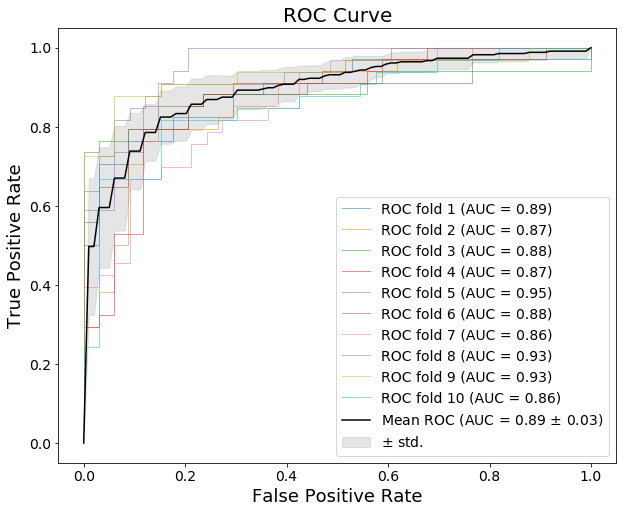

In [22]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2018).split(X, y)
classifier = svm.SVC(**optimizer.best_params_, probability=True)

tprs, aucs = [], []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,8))

for itr, (train, test) in enumerate(cv):
    progressBar(itr+1, n_splits) 
    
    # get predictions
    probs = classifier.fit(X[train], y[train]).predict_proba(X[test])
    
    # compute AUC
    fpr, tpr, thresholds = roc_curve(y[test], probs[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(
        fpr, tpr, lw=1, alpha=0.5,
        label='ROC fold %d (AUC = %0.2f)' % (itr+1, roc_auc)
    )

# plot avg AUC    
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(
    mean_fpr, mean_tpr, color='k',
    label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc)
)

# plot std
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(
    mean_fpr, tprs_lower, tprs_upper,
    color='grey', alpha=.2, label=r'$\pm$ std.'
)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('ROC Curve', fontsize=20)
plt.legend(loc="lower right", fontsize=14)
plt.show()

[=================================================>] 100%

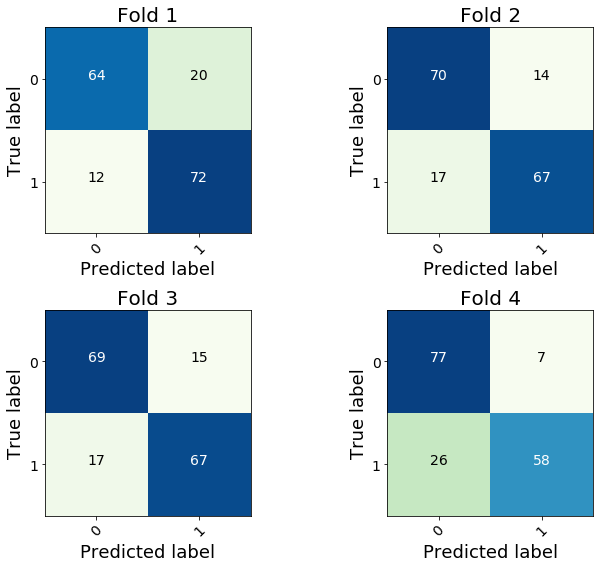

In [23]:
n_splits = 4
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2018).split(X, y)
classifier = svm.SVC(**optimizer.best_params_, probability=True)
classes = df.ca.unique()

fig = plt.figure(figsize=(10,8))
for itr, (train, test) in enumerate(cv):
    progressBar(itr+1, n_splits) 
        
    # get predictions
    y_pred = classifier.fit(X[train], y[train]).predict(X[test])
    
    # compute confusion matrix
    matrix = confusion_matrix(y[test], y_pred)
    
    # plot confusion matrix
    ax = fig.add_subplot(2,2,itr+1)
    ax.imshow(matrix, interpolation='nearest', cmap=plt.cm.GnBu)
    
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(
            j, i, format(matrix[i, j], 'd'),
            horizontalalignment="center",
            fontsize=14, color="white" if matrix[i, j] > matrix.max()/2 else "black"
        )
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.title('Fold %d' % (itr+1), fontsize=20)

plt.tight_layout()